# Feature and Structure Independence

### Libs

In [385]:
## libs 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools
import time
import math

# Computation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler

import scipy
from scipy.stats.stats import pearsonr 
import scipy.stats as stats

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import random_graphs

## node colour
orig_cmap = plt.cm.PuBu

### Supporting Function

In [386]:
## supporting functions
from support.preprocessing import sort_adjacency, reshape_A, calculate_A_shape, reconstruct_adjacency, pad_matrix, unpad_matrix, prepare_in_out
from support.metrics import compute_mig, compute_mi
from support.graph_generating import generate_single, generate_manifold, generate_topol_manifold, generate_topol_manifold
from support.latent_space import vis2D, visDistr
from support.comparing import compare_manifold_adjacency, compare_topol_manifold
from support.plotting import shiftedColorMap

## graph sampling
from sampling import ForestFire, Metropolis_Hastings, Random_Walk, Snowball, Ties, Base_Samplers

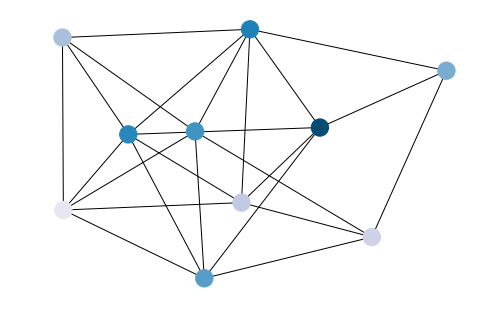

In [387]:
def get_graph(n,p,draw): 

    g = random_graphs.erdos_renyi_graph(n, p, seed=None, directed=False)

    if draw:
        f = np.random.rand(n)
        orig_cmap = plt.cm.PuBu
        fixed_cmap = shiftedColorMap(orig_cmap, start=min(f), midpoint=0.5, stop=max(f), name='fixed')
        nx.draw(g, node_color=f, font_color='white', cmap = fixed_cmap)
        plt.show()
    
    return g

g = get_graph(n = 10, p = 0.4, draw = True)

In [388]:
def sort_adj(g):
    node_k1 = dict(g.degree())  # sort by degree
    node_k2 = nx.average_neighbor_degree(g)  # sort by neighbor degree
    node_closeness = nx.closeness_centrality(g)
    node_betweenness = nx.betweenness_centrality(g)

    node_sorting = list()

    ## sort topology amd attributes _________________
    
    #for node_id in range(0, len(g)):
    for node_id in g.nodes():
        node_sorting.append(
            (node_id, node_k1[node_id], node_k2[node_id], node_closeness[node_id], node_betweenness[node_id]))

    node_descending = sorted(node_sorting, key=lambda x: (x[1], x[2], x[3], x[4]), reverse=True)

    mapping = dict()
    #f_sorted = f

    for i, node in enumerate(node_descending):
        mapping[node[0]] = i
        #f_sorted[i] = node_descending[i][5]

    a = nx.adjacency_matrix(g, nodelist=mapping.keys()).todense()
    g = nx.relabel_nodes(g, mapping)  # change node_id according to ordering
        

    return g, a

In [423]:
def pad_attributes(f, dataArgs):

    ## padding attributes vector with zeroes
    if dataArgs["n_max"] - f.shape[0] > 0:
        zeroes = np.zeros((dataArgs["n_max"] - f.shape[0], dataArgs["n_features"]))
        f = np.concatenate((f, zeroes))
        
    return f


def unpad_attr(f, nodes_n, analyzeArgs, dataArgs):
    
    f = f[:nodes_n, :]  ## shorten
    
    if analyzeArgs["normalize_feature"]:
        f = (f - np.min(f))/np.ptp(f)    ## normalize feature values
        
    if dataArgs["n_features"] == 1:
        f = np.reshape(f, (f.shape[0]))  ## reshape
    
    return f

In [390]:
def prepare_in_out(diag_offset, A_shape, F_shape):    

    if diag_offset <= -2:  # matrix input
        return ((F_shape[1], F_shape[2]), (A_shape[0], A_shape[1], 1)), ((F_shape[1], F_shape[2]), (A_shape[0], A_shape[1], 1))

In [525]:
def generate_data(dataArgs): 
    
    
    ## Data ________________________________

    G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
    F = np.zeros((dataArgs["n_graphs"], dataArgs["n_max"], dataArgs["n_features"]))
    print("feature_dependence:",dataArgs["feature_dependence"] )
    
    
    ## Generate Graph Data_______________________________

    for i in tqdm(range(0,dataArgs["n_graphs"])):
        
        ## Generate Graph Type ______________________________________________

        if dataArgs["fix_n"] == True:
            n = dataArgs["n_max"] # generate fixed number of nodes n_max
        else:
            n = random.randint(1, dataArgs["n_max"]) # generate number of nodes n between 1 and n_max and

            
        p = np.random.rand(1)  # float in range 0 - 1 
        g = get_graph(n, p, draw = False)
                     
        #nx.draw(g, cmap=plt.get_cmap('PuBu'), node_color=np.squeeze(f), font_color='white')
        #plt.show()
        
        g, a = sort_adj(g)
        a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal        
        a_transformed = reshape_A(a, diag_offset = dataArgs["diag_offset"])
        
        
        ## Generate / Load Node Features ______________________________________________

        if dataArgs["feature_dependence"] == "random":
            f = np.random.rand(n, dataArgs["n_features"])                   ## float
            #F[i] = np.random.randint(2, size=(dataArgs["n_max"],dataArgs["n_features"]))   ## int
            
        if dataArgs["feature_dependence"] == "norm_degree":
            if dataArgs["n_features"] == 1:
                
                f = np.asarray([int(x[1]) for x in sorted(g.degree())])  
                f = (f) / (max(f)+1)
                f = np.reshape(f, (f.shape[-1],1))
                
                    
        if dataArgs["feature_dependence"] == "degree":
            if dataArgs["n_features"] == 1:
                
                f = np.asarray([int(x[1]) for x in sorted(g.degree())])  
                f = (f+1) / (dataArgs["n_max"]+1)
                f = np.reshape(f, (f.shape[-1],1))
                
                
        if dataArgs["feature_dependence"] == "p":  
            if dataArgs["n_features"] == 1:
                f = np.ones((n , 1)) * p
        
        ## pad features with zeroes
        f = pad_attributes(f, dataArgs)


        
        ## Build Data Arrays___________________________________________________

        F[i] = f
        G[i] = a_transformed


    ## Input and Output Size ___________________________________________________________

    input_shape, output_shape = prepare_in_out(dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]), F.shape)
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    ## scale features in F for smoother training
    #scaler = MinMaxScaler()
    #scaler.fit(F)
    #F = scaler.transform(F)
    
    return G, F, input_shape,output_shape
    
dataArgs = {"n_graphs": 10000, "n_max": 16, "feature_dependence": "degree", "fix_n": False, "diag_offset": -2, "diag_value": 1, "clip": True, "n_features": 1}  #"diag_offset" - 1 == full adjacency
G, F, input_shape, output_shape = generate_data(dataArgs)

feature_dependence: degree


input_shape: ((16, 1), (16, 16, 1)) , output_shape: ((16, 1), (16, 16, 1))


# beta-VAE Model

In [526]:
## Model Setup
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Dropout, Activation, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split
from support.keras_dgl.utils import *
from support.keras_dgl.layers import MultiGraphCNN


class VAE():

    # reparameterization trick
    # instead of sampling from Q(z|X), sample eps = N(0,I)
    # then z = z_mean + sqrt(var)*eps

    def sampling(self, args):
        """Reparameterization trick by sampling fr an isotropic unit Gaussian.
        # Arguments
            args (tensor): mean and log of variance of Q(z|X)
        # Returns
            z (tensor): sampled latent vector
        """

        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    
    
    def __init__(self, modelArgs, trainArgs, g_train, g_test, f_train, f_test):

        ## MODEL ______________________________________________________________       
            
        ## Graph Neural Network Architecture __________________________________
            
        ## 1) build encoder model____________________________________

        # build graph_conv_filters
        SYM_NORM = True
        num_filters = 2
        print("g_train shape:", g_train.shape)
        graph_conv_filters = preprocess_adj_tensor_with_identity(np.squeeze(g_train), SYM_NORM)

        # build model
        X_input = Input(shape=(f_train.shape[1], f_train.shape[2]))
        graph_conv_filters_input = Input(shape=(graph_conv_filters.shape[1], graph_conv_filters.shape[2]))

        # define inputs of features and graph topologies
        inputs = [X_input, graph_conv_filters_input]

        x = MultiGraphCNN(100, num_filters, activation='elu')([X_input, graph_conv_filters_input])
        x = Dropout(0.2)(x)
        x = MultiGraphCNN(100, num_filters, activation='elu')([x, graph_conv_filters_input])
        x = Dropout(0.2)(x)
        x = Lambda(lambda x: K.mean(x, axis=1))(x)  # adding a node invariant layer to make sure output does not depends upon the node order in a graph.
        z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
        z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(modelArgs["latent_dim"],), name='z')([z_mean, z_log_var])


        ## 2.1) build topology decoder model __________________________

        ## shape info needed to build decoder model
        inputs_2D_encoder = Input(shape=modelArgs["input_shape"][1], name='encoder_input')
        x_2D = inputs_2D_encoder
        for i in range(2):
            modelArgs['filters'] *= 2
            x_2D = Conv2D(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'], activation='relu',strides=2, padding='same')(x_2D)
        shape_2D = K.int_shape(x_2D)

        latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
        x_2D = Dense(shape_2D[1] * shape_2D[2] * shape_2D[3], activation='relu')(latent_inputs)
        x_2D = Reshape((shape_2D[1], shape_2D[2], shape_2D[3]))(x_2D)

        for i in range(2):
            x_2D = Conv2DTranspose(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'],activation='relu', strides=2, padding='same')(x_2D)
            modelArgs['filters'] //= 2

        topol_output = Conv2DTranspose(filters=1, kernel_size=modelArgs['kernel_size'], activation='sigmoid',padding='same', name='decoder_output')(x_2D)


        ## 2.2) build attribute decoder model __________________________

        y = Dense(4, activation='relu')(latent_inputs)
        y = Dense(12, activation='relu')(latent_inputs)
        y = Dense(12, activation='relu')(latent_inputs)
        y = Dense(modelArgs["output_shape"][0][0], activation='sigmoid')(y)
        attr_output = Reshape(modelArgs["output_shape"][0])(y)

     
    
        ## INSTANTIATE___________________________________

        encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        encoder.summary()

        ## 2.1) instantiate topology decoder model
        topol_decoder = Model(latent_inputs, topol_output, name='topol_decoder')
        topol_decoder.summary()
        
        ## 2.2) instantiate feature decoder model
        attr_decoder = Model(latent_inputs, attr_output, name='attr_decoder')
        attr_decoder.summary()

        
        ## 3) instantiate VAE model
        attr_outputs = topol_decoder(encoder(inputs)[2])
        topol_outputs = attr_decoder(encoder(inputs)[2])
        vae = Model(inputs, [attr_outputs, topol_outputs], name='vae')

    

        ## LOSS FUNCTIONS ______________________________________
        
        def attr_loss_func(y_true, y_pred):

            ## RECONSTRUCTION LOSS_______________________            
            ## mean squared error
            attr_reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
            attr_reconstruction_loss *= modelArgs["input_shape"][0][0]
                            
            ## KL LOSS _____________________________________________

            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5

            ## COMPLETE LOSS __________________________________________________

            loss = K.mean(attr_reconstruction_loss + (trainArgs["beta"] * kl_loss))

            return loss
        
        
        
        def topol_loss_func(y_true, y_pred):
            
            ## RECONSTRUCTION LOSS_______________________
            ## binary cross-entropy
            topol_reconstruction_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
            topol_reconstruction_loss *= (modelArgs["input_shape"][1][0] * modelArgs["input_shape"][1][1])
                            
            ## KL LOSS _____________________________________________

            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5

            ## COMPLETE LOSS __________________________________________________

            loss = K.mean(topol_reconstruction_loss + (trainArgs["beta"] * kl_loss))

            return loss
        
    
    
    
        ## MODEL COMPILE______________________________________________
        
        vae.compile(optimizer='adam', loss={"attr_decoder": attr_loss_func, "topol_decoder": topol_loss_func})
        vae.summary()
        
        

        ## TRAIN______________________________________________

        # load the autoencoder weights

        if trainArgs["weights"] == "load":

            vae.load_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

        # train the autoencoder

        elif trainArgs["weights"] == "train":

            # Set callback functions to early stop training and save the best model so far
            callbacks = [EarlyStopping(monitor='val_loss', patience=trainArgs["early_stop"]), ModelCheckpoint(filepath="models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5",save_best_only=True)]

            # build graph_conv_filters
            SYM_NORM = True
            g_train_mod = preprocess_adj_tensor_with_identity(np.squeeze(g_train), SYM_NORM)
            g_test_mod = preprocess_adj_tensor_with_identity(np.squeeze(g_test), SYM_NORM)

            vae.fit([f_train, g_train_mod], {"attr_decoder": f_train, "topol_decoder": g_train}, epochs=trainArgs["epochs"],batch_size=trainArgs["batch_size"], callbacks=callbacks,validation_data=([f_test, g_test_mod], {"attr_decoder": f_test, "topol_decoder": g_test}))
            vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

            self.model = (encoder, topol_decoder, attr_decoder)
            self.data = (f_test, [g_test_mod, g_test])

In [535]:
modelArgs = {"nn_architecture": "gnn", "latent_dim": 2, "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape, "param_loss": False,}
trainArgs = {"beta": 1, "loss": "mse", "weights": "train", "early_stop": 1, "batch_size": 16, "epochs": 50, "data_split": 0.2}


## Train and Validation Split _______________________________________________
g_train, g_test, f_train, f_test = train_test_split(G, F, test_size=trainArgs["data_split"],random_state=1, shuffle=True)

vae = VAE(modelArgs, trainArgs, g_train, g_test, f_train, f_test)

models = vae.model 
data = vae.data

g_train shape: (8000, 16, 16, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           (None, 16, 1)        0                                            
__________________________________________________________________________________________________
input_64 (InputLayer)           (None, 32, 16)       0                                            
__________________________________________________________________________________________________
multi_graph_cnn_63 (MultiGraphC (None, 16, 100)      300         input_63[0][0]                   
                                                                 input_64[0][0]                   
__________________________________________________________________________________________________
dropout_63 (Dropout)            (None, 16, 100)      0           multi_graph

8000/8000 [==============================] - 6s 804us/step - loss: 48.2637 - topol_decoder_loss: 44.6612 - attr_decoder_loss: 3.6025 - val_loss: 46.9104 - val_topol_decoder_loss: 43.3565 - val_attr_decoder_loss: 3.5539
Epoch 9/50
8000/8000 [==============================] - 6s 800us/step - loss: 47.8991 - topol_decoder_loss: 44.2478 - attr_decoder_loss: 3.6513 - val_loss: 47.2673 - val_topol_decoder_loss: 43.5543 - val_attr_decoder_loss: 3.7130


# Analysis

In [528]:
## unpad the adjacency matrix by looking at diagonal values

def unpad_matrix(max_adjacency, diag_value, node_margin, fix_n):
    
    nodes_n = max_adjacency.shape[0]

    if fix_n == False:
        keep = list()
        for i in range(0, max_adjacency.shape[0]):
            if max_adjacency[i][i] >= diag_value - node_margin:
                keep.append(i)

        ## delete rows and columns
        max_adjacency = max_adjacency[:, keep]  # keep columns
        max_adjacency = max_adjacency[keep, :]  # keep rows
        
        nodes_n = len(keep)
        
    return max_adjacency, nodes_n


## pad the adjacency matrix to adhere to fixed size n_max

def pad_matrix(a, n_max, diag_value):
    ## fill the diagonal with fill_diag

    np.fill_diagonal(a, diag_value)

    max_adjacency = np.zeros([n_max, n_max])
    max_adjacency[:a.shape[0], :a.shape[1]] = a

    return max_adjacency


In [529]:
def generate_single_features(analyzeArgs, modelArgs, dataArgs, models):
    
    encoder, topol_decoder, attr_decoder = models  # trained models

    print("latent dimensions:", modelArgs["latent_dim"])

    z_sample = np.zeros(modelArgs["latent_dim"])
    z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))

    for i, dim in enumerate(analyzeArgs["z"]):
        z_sample[0][dim] = analyzeArgs["activations"][i]

    a_decoded = topol_decoder.predict(z_sample)
    f_decoded = attr_decoder.predict(z_sample)
        
    ## reconstruct upper triangular adjacency matrix
    reconstructed_a = reconstruct_adjacency(a_decoded, dataArgs["clip"], dataArgs["diag_offset"])
    reconstructed_a, nodes_n = unpad_matrix(reconstructed_a, dataArgs["diag_value"], 0.1, dataArgs["fix_n"])
    
    reconstructed_f = unpad_attr(f_decoded[0], nodes_n, analyzeArgs, dataArgs)
       
    print("nodes_n:", nodes_n)
    print("features:", reconstructed_f)

    
    ## reconstruct graph
    g = nx.from_numpy_matrix(reconstructed_a)
    fixed_cmap = shiftedColorMap(orig_cmap, start=min(reconstructed_f), midpoint=0.5, stop=max(reconstructed_f), name='fixed')
    nx.draw(g, node_color=reconstructed_f, font_color='white', cmap = fixed_cmap)
    plt.show()
    
    ax = sns.distplot(reconstructed_f, rug = True)
    ax.set_title('Node Feature Distribution', fontweight = "bold")
    ax.set(xlabel="feature value", ylabel="frequency")
    plt.show()
    

latent dimensions: 2
nodes_n: 15
features: [0.9991139  0.9972417  0.9977071  0.9979389  0.9963788  0.992242
 0.99638295 0.99488306 0.9951564  0.9990025  0.9995638  0.99994445
 0.9999701  0.9999141  0.99937665]


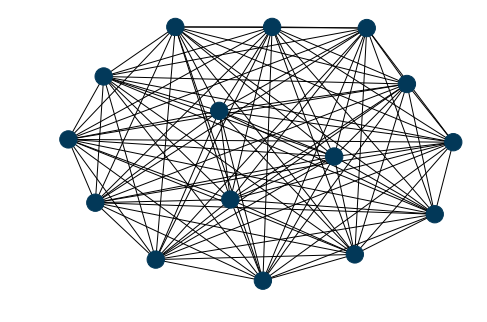

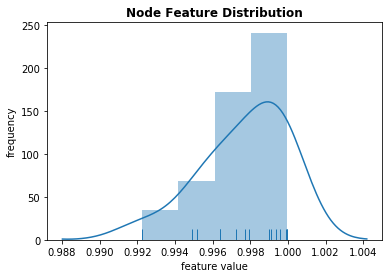

In [534]:
analyzeArgs = {"z": [0,1], "activations": [10,-10], "normalize_feature": False}
generate_single_features(analyzeArgs, modelArgs, dataArgs, models)

## Modification (Nullhypothesis Testing)

ground truth attribute dependence:  degree
[[0.76470588]
 [0.70588235]
 [0.70588235]
 [0.70588235]
 [0.70588235]
 [0.64705882]
 [0.64705882]
 [0.58823529]
 [0.58823529]
 [0.58823529]
 [0.58823529]
 [0.52941176]
 [0.41176471]
 [0.        ]
 [0.        ]
 [0.        ]]
[[0.70588235]
 [0.41176471]
 [0.58823529]
 [0.58823529]
 [0.76470588]
 [0.70588235]
 [0.70588235]
 [0.58823529]
 [0.58823529]
 [0.70588235]
 [0.64705882]
 [0.52941176]
 [0.64705882]
 [0.        ]
 [0.        ]
 [0.        ]]


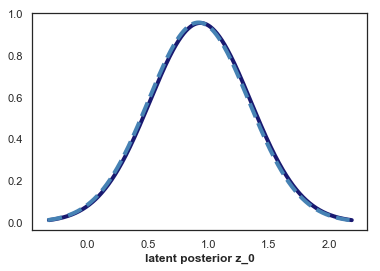

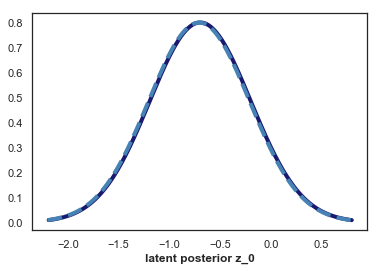

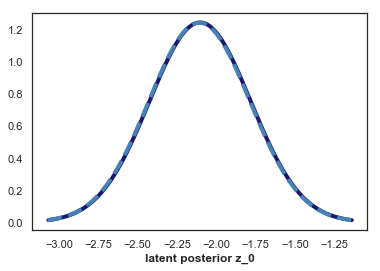

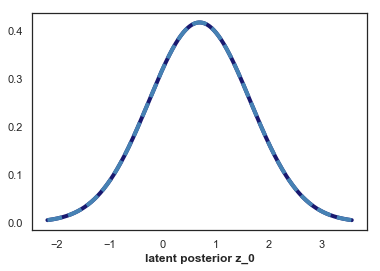

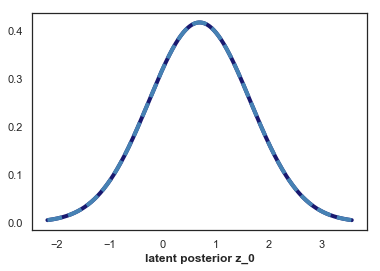

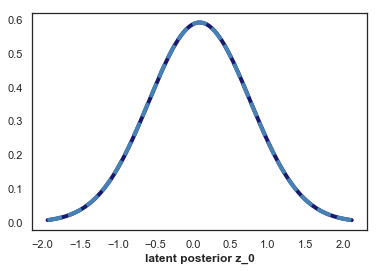

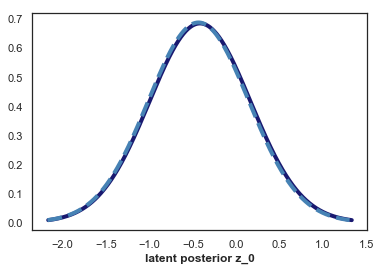

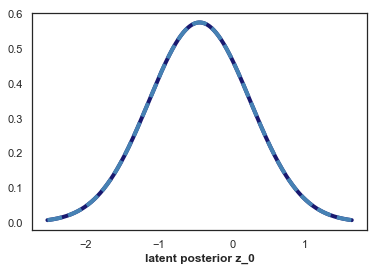

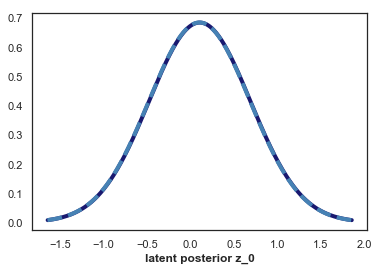

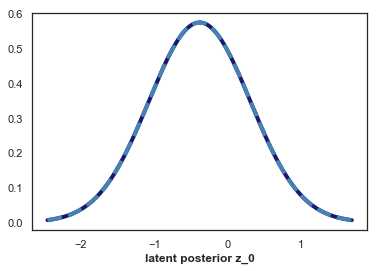

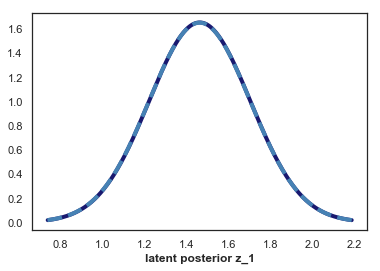

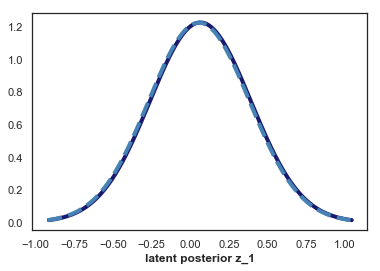

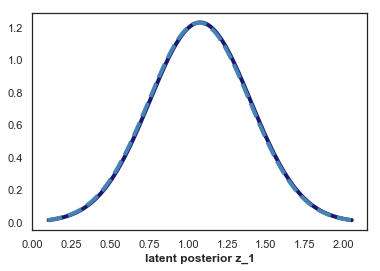

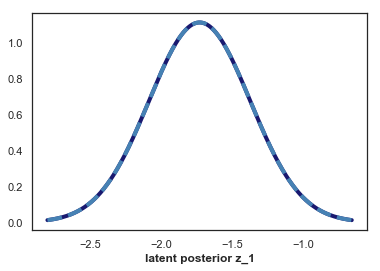

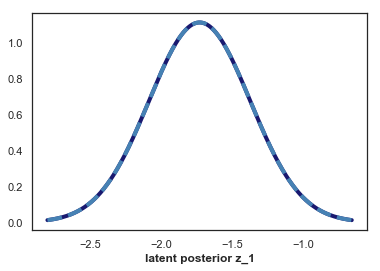

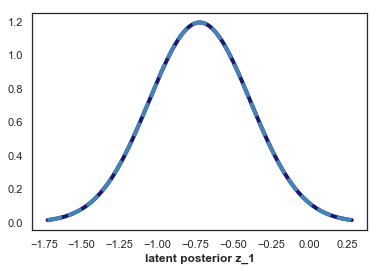

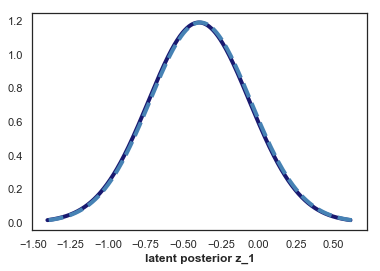

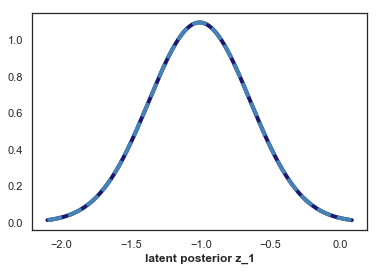

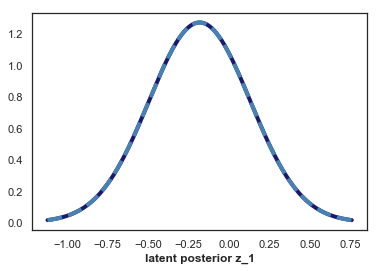

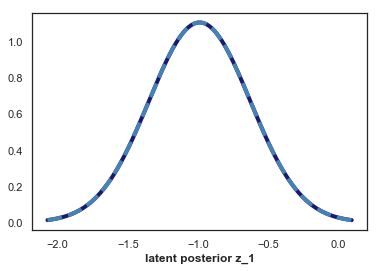

total_mean_shift: 0


In [557]:
def modification_comparison(analyzeArgs, modelArgs, models, data, batch_size=128,model_name="vae_graph"):

    ## unpack models and data__________________________
    
    encoder, topol_decoder, attr_decoder = models  # trained models
    F_org, [A_fil, A] = data

    F_mod = np.copy(F_org)
    
    for i, (f,a) in enumerate(zip(F_mod, A)):

        ## Generate Graph Type ______________________________________________
            
        reconstructed_a, nodes_n = unpad_matrix(a, dataArgs["diag_value"], 0.2, dataArgs["fix_n"])
        f = unpad_attr(f, nodes_n, analyzeArgs, dataArgs)
        f = np.reshape(f, (f.shape[0], 1)) ## reshape to (n,n_features)
        
        if analyzeArgs["f_variation"] == "random":
            for mod in range(0, int(analyzeArgs["mod_degree"] * nodes_n)):
                swap = np.random.randint(low = 0, high = nodes_n, size = 2)
                temp = np.copy(f[swap[0]])
                f[swap[0]] = f[swap[1]]
                f[swap[1]] = temp


        elif analyzeArgs["f_variation"] == "equal":
    
            norm_std = analyzeArgs["mod_degree"]
            norm_mean = np.mean(f) 
            
            for i in range(0,len(f)):
                
                if f[i] > norm_mean:
                    f[i] = f[i] - (norm_std * (np.abs(f[i] - norm_mean)))
                else:
                    f[i] = f[i] + (norm_std * (np.abs(f[i] - norm_mean )))
                    
                    
        elif analyzeArgs["f_variation"] == "uniform":
    
            f = np.ones(f.shape[0]) * analyzeArgs["mod_degree"]
            f = np.reshape(f, (f.shape[-1],1))
                    
        
        ## pad features with zeroes
        f = pad_attributes(f, dataArgs)
        


    ## ENCODER - 2D Digit Classes ______________________________________________

    z_mean, z_log_var, _ = encoder.predict([F_org, A_fil], batch_size = batch_size)
    z_mean_mod, z_log_var_mod, _ = encoder.predict([F_mod, A_fil], batch_size = batch_size)
        
        
    ## toDO: measure the correlation between latent variable and the generative factor / features

    
    ## Feature Change ____________________________ 
        
    z_mean = z_mean[:analyzeArgs["n_graphs"]]
    z_mean_mod = z_mean_mod[:analyzeArgs["n_graphs"]]
    z_var = np.exp(0.5 * z_log_var)[:analyzeArgs["n_graphs"]]
    z_var_mod = np.exp(0.5 * z_log_var_mod)[:analyzeArgs["n_graphs"]]
    
    total_mean_shift = 0
    
    for latent_i in range(0, modelArgs["latent_dim"]):
        for graph_i in range(0, analyzeArgs["n_graphs"]):

            ## compute correlation and standardized covariance
            #mean_shift = np.abs(z_mean[latent_i] - z_mean_mod[latent_i])
            #total_mean_shift += mean_shift

            x = np.linspace(z_mean[graph_i, latent_i] - 3*math.sqrt(z_var[graph_i, latent_i]), z_mean[graph_i, latent_i] + 3*math.sqrt(z_var[graph_i, latent_i]), 1000)
            y = stats.norm.pdf(x, z_mean[graph_i, latent_i], math.sqrt(z_var[graph_i, latent_i]))
            plt.plot(x, y, color='midnightblue', linestyle='solid', linewidth=4)

            x_mod = np.linspace(z_mean_mod[graph_i, latent_i] - 3*math.sqrt(z_var_mod[graph_i, latent_i]), z_mean_mod[graph_i, latent_i] + 3*math.sqrt(z_var_mod[graph_i, latent_i]), 1000)
            y_mod = stats.norm.pdf(x_mod, z_mean_mod[graph_i, latent_i], math.sqrt(z_var_mod[graph_i, latent_i]))
            plt.plot(x_mod, y_mod, color='steelblue', linestyle='dashed', linewidth=4)

            plt.xlabel('latent posterior z_' + str(latent_i), fontweight = "bold")
            #plt.annotate("mean shift:" + str(mean_shift) , xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')

            plt.show()
        
    
    print("total_mean_shift:", total_mean_shift)

    

        
## PLOT RESULTS ________________________________________
print("ground truth attribute dependence: ", dataArgs["feature_dependence"])
analyzeArgs = {"mod_degree": 1.0, "n_graphs": 10, "f_variation": "random", "metric": "none", "normalize_feature": False}
modification_comparison(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Latent Variable Correlation

change!! Does not make sense because mean out the difference!

ground truth attribute dependence:  degree


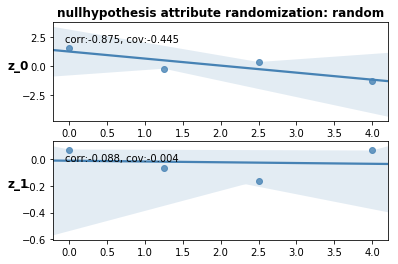

In [533]:
def feature_latent_correlation(analyzeArgs, modelArgs, models, data, batch_size=128,model_name="vae_graph"):

    
    ## unpack models and data__________________________
    
    encoder, topol_decoder, attr_decoder = models  # trained models
    F, [A_fil, A] = data
                
    mod_degree = np.linspace(0,dataArgs["n_max"],analyzeArgs["n_config_graphs"], dtype = int)      
        
    ## topol parameters
    topol_params = ["density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]

    ## store graphs and targets
    # shape: n_config_graphs, params, upper_A_size
    A_mod = np.zeros((analyzeArgs["n_config_graphs"], *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
    F_mod = np.zeros((analyzeArgs["n_config_graphs"], dataArgs["n_max"], dataArgs["n_features"]))
    

    for i, (a, f) in enumerate(zip(A[:analyzeArgs["n_config_graphs"]], F[:analyzeArgs["n_config_graphs"]])):

        ## Generate Graph Type ______________________________________________
            
        reconstructed_a, nodes_n = unpad_matrix(a, dataArgs["diag_value"], 0.2, dataArgs["fix_n"])
        f = unpad_attr(f, nodes_n, analyzeArgs, dataArgs)
        f = np.reshape(f, (f.shape[0], 1)) ## reshape to (n,n_features)
        
        if analyzeArgs["f_variation"] == "random":
            for mod in range(0, mod_degree[i]):
                swap = np.random.randint(low = 0, high = f.shape[0], size = 2)
                temp = f[swap[0]]
                f[swap[0]] = f[swap[1]]
                f[swap[1]] = temp
                
                
        elif analyzeArgs["f_variation"] == "equal":
    
            norm_std = mod_degree[i] / max(mod_degree)
            norm_mean = np.mean(f) 
            
            for i in range(0,len(f)):
                
                if f[i] > norm_mean:
                    f[i] = f[i] - (norm_std * (np.abs(f[i] - norm_mean)))
                else:
                    f[i] = f[i] + (norm_std * (np.abs(f[i] - norm_mean )))
                    
                    
        elif analyzeArgs["f_variation"] == "uniform":
    
            f = np.ones(f.shape[0]) * (mod_degree[i] / max(mod_degree))
            f = np.reshape(f, (f.shape[-1],1))
                    
                
        ## pad features with zeroes
        f = pad_attributes(f, dataArgs)
        F_mod[i] = f    
        

    ## ENCODER ______________________________________________
    z_mean, _, _ = encoder.predict([F_mod, A_fil], batch_size = batch_size)


    ## Measure the Mutual Information Gap ____________________________________________
    if analyzeArgs["metric"] == "mig":
        mig = compute_mig(mod_degree, np.squeeze(z_mean))
        
        
    ## toDO: measure the correlation between latent variable and the generative factor / features

    ## Visualize Latent Variables x Feature Change ____________________________

    fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= 1)

    for latent_z, row in enumerate(ax):        

            y = z_mean[:,latent_z]
            x = mod_degree / mod_degree.shape[0]
            sns.regplot(x, y, color="steelblue", ax=row)

            ## compute correlation and standardized covariance
            corr = round(pearsonr(x,y)[0],3)
            cov = round(np.cov(x, y)[0][1]/max(x),3)
            row.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')

            

    ## add row and column titles _____________________

    rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
    cols = [t for t in ["nullhypothesis attribute randomization: " + str(analyzeArgs["f_variation"])]]

    for axis, col in zip(ax, cols):
        axis.set_title(col, fontweight='bold')

    for axis, row in zip(ax, rows):
        axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')


        
## PLOT RESULTS ________________________________________
print("ground truth attribute dependence: ", dataArgs["feature_dependence"])
analyzeArgs = {"n_config_graphs": 4, "f_variation": "random", "metric": "none", "normalize_feature": False}
feature_latent_correlation(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")